In [266]:
 # Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi 
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
from pathlib import Path
import requests
import urllib.request
import json
import pprint
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

%matplotlib inline

In [267]:
 # Load .env enviroment variables
load_dotenv()

True

In [268]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
print(f"ALP Key type:{type(alpaca_secret_key)}")

ALP Key type:<class 'str'>


In [269]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [270]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2015-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-01-05', tz='America/New_York').isoformat()
timeframe='1D'

In [271]:
 # Get 5 years' worth of historical data for SPY 
tickers = ['SPY']
df_sp500_data = alpaca.get_barset(tickers, timeframe, start = start_date, end = end_date).df
# Display sample data
df_sp500_data.head()

SPY                                    
                             open    high      low   close     volume
2015-01-02 00:00:00-05:00  206.38  206.88  204.180  205.41   94506045
2015-01-05 00:00:00-05:00  204.17  204.37  201.350  201.80  133100354
2015-01-06 00:00:00-05:00  202.09  202.72  198.855  199.82  166955423
2015-01-07 00:00:00-05:00  201.42  202.72  200.880  202.34  103285826
2015-01-08 00:00:00-05:00  204.00  206.16  203.990  205.92  112316394

In [272]:
df_sp500_data.index=df_sp500_data.index.date
df_sp500_data.head()

SPY                                    
              open    high      low   close     volume
2015-01-02  206.38  206.88  204.180  205.41   94506045
2015-01-05  204.17  204.37  201.350  201.80  133100354
2015-01-06  202.09  202.72  198.855  199.82  166955423
2015-01-07  201.42  202.72  200.880  202.34  103285826
2015-01-08  204.00  206.16  203.990  205.92  112316394

In [273]:
df_sp500_data.dtypes

SPY  open      float64
     high      float64
     low       float64
     close     float64
     volume      int64
dtype: object

In [274]:
sp500_daily_returns = df_sp500_data['SPY']['close'].pct_change()
sp500_daily_returns.head()

2015-01-02         NaN
2015-01-05   -0.017575
2015-01-06   -0.009812
2015-01-07    0.012611
2015-01-08    0.017693
Name: close, dtype: float64

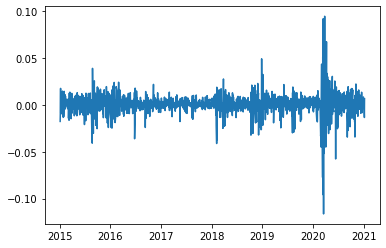

In [275]:
sp500_daily_returns.plot()

In [276]:
#calculate cumulative returns
cumulative_returns = (1+ sp500_daily_returns).cumprod()-1
cumulative_returns.head()

2015-01-02         NaN
2015-01-05   -0.017575
2015-01-06   -0.027214
2015-01-07   -0.014946
2015-01-08    0.002483
Name: close, dtype: float64

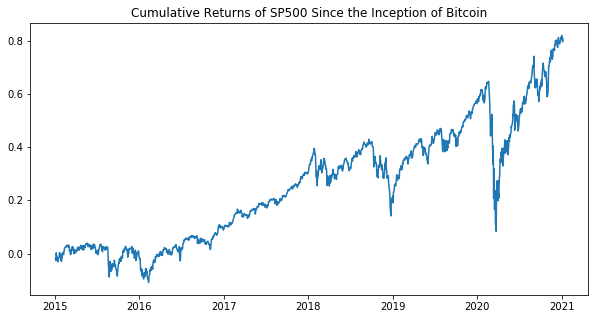

In [277]:
cumulative_returns.plot(figsize=(10,5), title="Cumulative Returns of SP500 Since the Inception of Bitcoin")

In [278]:
daily_std = sp500_daily_returns.std()
daily_std

0.011728063578689116

In [279]:
#calculate the annualized std(252 trading days)
annualized_std = daily_std*np.sqrt(252)
annualized_std

0.18617723753739363

In [280]:
# Calculate the rolling standard deviation for all portfolios using a 21-day window

rolling_std = sp500_daily_returns.rolling(window=21).std()
rolling_std

2015-01-02         NaN
2015-01-05         NaN
2015-01-06         NaN
2015-01-07         NaN
2015-01-08         NaN
                ...   
2020-12-29    0.005931
2020-12-30    0.005792
2020-12-31    0.005436
2021-01-04    0.006268
2021-01-05    0.006419
Name: close, Length: 1513, dtype: float64

In [281]:
# Plot the rolling standard deviation
sp500_rolling_plot = rolling_std.hvplot()
sp500_rolling_plot

:Curve   [index]   (close)

In [282]:
# Calculate the correlation
#rolling_std_all.corr()

In [283]:
# Display the correlation matrix
#correlation = rolling_std.corr()
#sns.heatmap(correlation, vmin=-1,vmax=1)

In [284]:
load_dotenv()
access_token = os.getenv("COIN_API")
headers = { 'Authorization': 'Bearer ' + access_token }
puell_url= "https://api.cryptoquant.com/v1/btc/network-indicator/puell-multiple?window=day&from=20150101&limit=100000"
response = requests.get(puell_url, headers=headers)

In [285]:
response


<Response [200]>

In [286]:
puell_data = response.json()

puell_df = pd.DataFrame(data=puell_data['result']['data'])
puell_df['date']=pd.to_datetime(puell_df['date'])
#puell_df=puell_df.set_index('date')
#puell_df = puell_df.pct_change()

In [287]:
puell_df.head(10)


,date,puell_multiple
0,2021-01-22,2.123790
1,2021-01-21,2.032633
2,2021-01-20,2.309534
3,2021-01-19,2.564989
4,2021-01-18,2.428575
5,2021-01-17,2.178111
6,2021-01-16,2.537028
7,2021-01-15,2.859884
8,2021-01-14,2.809784
9,2021-01-13,2.606989


In [288]:
def get_puell_multiple_data():
    
    load_dotenv()
    access_token = os.getenv("COIN_API")
    headers = { 'Authorization': 'Bearer ' + access_token }
    puell_url= "https://api.cryptoquant.com/v1/btc/network-indicator/puell-multiple?window=day&from=20150101&limit=100000"
    response = requests.get(puell_url, headers=headers)
    puell_data = response.json()

    puell_df = pd.DataFrame(data=puell_data['result']['data'])
    puell_df['date']=pd.to_datetime(puell_df['date'])
    
    return puell_df

In [289]:
puell_plot = puell_df.hvplot(x='date',y='puell_multiple',sort_date = True)

In [290]:
puell_plot = puell_df.hvplot()
puell_plot

:Curve   [index]   (puell_multiple)

In [291]:
#puell = get_puell_multiple_data()

In [292]:
#Puell Multiple = Daily Coin Issuance(USD)/MA365(Daily Coin Issuance(USD))

In [293]:
#Indicator Overview
#This metric looks at the supply side of Bitcoin's economy - bitcoin miners and their revenue.
#It explores market cycles from a mining revenue perspective. Bitcoin miners are sometimes referred to as compulsory sellers due to their need to cover fixed costs of mining hardware in a market where price is extremely volatile. The revenue they generate can therefore influence price over time.

#The Puell Multiple is calculated by dividing the daily issuance value of bitcoins (in USD) by the 365-day moving average of daily issuance value.

In [294]:
#How It Can Be Used
#There are periods of time where the value of bitcoins being mined and entering the ecosystem is too great or too little relative to historical norms.
#Understanding these periods of time can be beneficial to the strategic Bitcoin investor.

#The chart below highlights periods where the value of Bitcoin's issued on a daily basis has historically been extremely low , which produced outsized returns for Bitcoin investors who bought Bitcoin here. It also shows periods where the daily issuance value was extremely high, providing advantageous profit-taking for Bitcoin investors who sold here.

In [295]:
'''
fig = px.line(
    puell,
    x='date',
    y='puell_multiple',
    title='Bitcoin Puell Multiple',
    labels={'date':'Daily','puell_multiple':'Puell Multiple'})
fig.show()
'''

"\nfig = px.line(\n    puell,\n    x='date',\n    y='puell_multiple',\n    title='Bitcoin Puell Multiple',\n    labels={'date':'Daily','puell_multiple':'Puell Multiple'})\nfig.show()\n"

In [296]:
    load_dotenv()
    access_token = os.getenv("COIN_API")
    headers = { 'Authorization': 'Bearer ' + access_token }

In [297]:
    BTC_price_data = "https://api.cryptoquant.com/v1/btc/market-data/price-usd?window=day&from=20150101&limit=100000"
    response_btc = requests.get(BTC_price_data, headers=headers)

    price_data_raw = response_btc.json()

    BTC_price_df = pd.DataFrame(data=price_data_raw['result']['data'])
    BTC_price_df = BTC_price_df.drop(['price_usd_high','price_usd_low','price_usd_open'], axis = 1)
    BTC_price_df['date'] = pd.to_datetime(BTC_price_df['date'])
    BTC_price_df['price_usd_close'] = BTC_price_df['price_usd_close'].astype(str).astype('float64')
    BTC_price_df = BTC_price_df.dropna()
    #BTC_price_df = BTC_price_df.set_index('date')
    #BTC_daily_returns_df = BTC_price_df.pct_change()

    BTC_price_df.head(100)

,date,price_usd_close
0,2021-01-22,32968.301667
1,2021-01-21,30848.486667
2,2021-01-20,35481.915000
3,2021-01-19,35888.901667
4,2021-01-18,36641.193333
...,...,...
95,2020-10-19,11750.000000
96,2020-10-18,11506.000000
97,2020-10-17,11363.000000
98,2020-10-16,11313.000000


In [298]:
#calculate cumulative returns
#btc_cumulative_returns = (1+ BTC_daily_returns_df).cumprod()-1
#btc_cumulative_returns.head()

In [299]:
#btc_cumulative_returns.plot(figsize=(10,5), title="Cumulative Returns of BTC Since 2015")

In [300]:
btc_plot = BTC_price_df.hvplot(x='date',y='price_usd_close',sort_date = True)

In [301]:
btc_plot

:Curve   [date]   (price_usd_close)

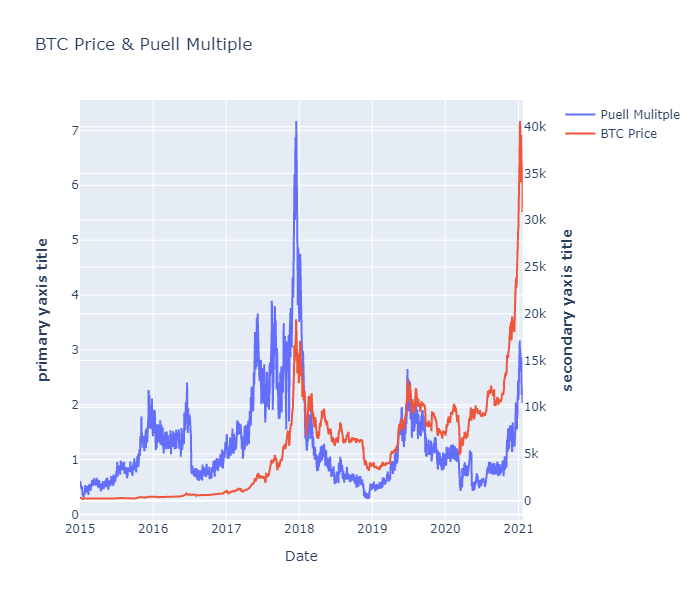

In [302]:
fig3 = make_subplots(specs=[[{'secondary_y':True}]])

#fig3=go.Figure()

fig3.add_trace(
    go.Scatter(mode = 'lines',x=puell_df['date'],y=puell_df['puell_multiple'], name = 'Puell Mulitple'),
    secondary_y=False 
)

fig3.add_trace(
    go.Scatter(mode = 'lines',x=BTC_price_df['date'], y =BTC_price_df ['price_usd_close'], name = 'BTC Price'),
    secondary_y=True 
)

fig3.update_layout(
    height = 600,width = 1500,
    title_text = 'BTC Price & Puell Multiple'
)

fig3.update_xaxes(title_text = 'Date')

fig3.update_yaxes(title_text='<b>primary<b> yaxis title', secondary_y= False)
fig3.update_yaxes(title_text='<b>secondary<b> yaxis title', secondary_y= True)



fig3.show()

In [303]:
def get_btc_price():

    load_dotenv()
    access_token = os.getenv("COIN_API")
    headers = { 'Authorization': 'Bearer ' + access_token }
    BTC_price_data = "https://api.cryptoquant.com/v1/btc/market-data/price-usd?window=day&from=20150101&limit=100000"
    response_btc = requests.get(BTC_price_data, headers=headers)

    price_data_raw = response_btc.json()

    BTC_price_df = pd.DataFrame(data=price_data_raw['result']['data'])
    BTC_price_df = BTC_price_df.drop(['price_usd_high','price_usd_low','price_usd_open'], axis = 1)
    BTC_price_df['date'] = pd.to_datetime(BTC_price_df['date'])
    BTC_price_df['price_usd_close'] = BTC_price_df['price_usd_close'].astype(str).astype('float64')
    
    BTC_price_df = BTC_price_df.dropna()
    
    return BTC_price_df

In [304]:
#btc = get_btc_price()

In [305]:
'''
fig1 = px.line(
    btc,
    x='date',
    y='price_usd_close',
    title='Bitcoin Closing Prices',
    labels={'date':'Daily','price_usd_close':'Daily Bitcoin Price'})
fig1.show()
'''

"\nfig1 = px.line(\n    btc,\n    x='date',\n    y='price_usd_close',\n    title='Bitcoin Closing Prices',\n    labels={'date':'Daily','price_usd_close':'Daily Bitcoin Price'})\nfig1.show()\n"

In [306]:
BTC_price_df.head()

,date,price_usd_close
0,2021-01-22,32968.301667
1,2021-01-21,30848.486667
2,2021-01-20,35481.915000
3,2021-01-19,35888.901667
4,2021-01-18,36641.193333


In [307]:
BTC_price_df = BTC_price_df.set_index('date')
BTC_price_df

,price_usd_close
date,
2021-01-22,32968.301667
2021-01-21,30848.486667
2021-01-20,35481.915000
2021-01-19,35888.901667
2021-01-18,36641.193333
...,...
2015-01-05,274.840000
2015-01-04,264.190000
2015-01-03,279.300000


In [308]:
btc_daily_returns=BTC_price_df['price_usd_close'].pct_change()
btc_daily_returns.head()

date
2021-01-22         NaN
2021-01-21   -0.064299
2021-01-20    0.150200
2021-01-19    0.011470
2021-01-18    0.020962
Name: price_usd_close, dtype: float64

In [309]:
btc_cumulative_returns = (1+ btc_daily_returns).cumprod()-1
btc_cumulative_returns.head()

date
2021-01-22         NaN
2021-01-21   -0.064299
2021-01-20    0.076243
2021-01-19    0.088588
2021-01-18    0.111407
Name: price_usd_close, dtype: float64

In [310]:
btc_cumulative_r_plot = btc_cumulative_returns.hvplot(x='date',y='price_usd_close',sort_date = True)

In [311]:
btc_cumulative_r_plot

:Curve   [date]   (price_usd_close)

In [312]:
btc_daily_std = btc_daily_returns.std()
btc_daily_std

0.040939729405044784

In [313]:
btc_annual_std = btc_daily_std*np.sqrt(252)
btc_annual_std

0.6498980564881609

In [314]:
btc_rolling_std = btc_daily_returns.rolling(window=21).std()
rolling_std

2015-01-02         NaN
2015-01-05         NaN
2015-01-06         NaN
2015-01-07         NaN
2015-01-08         NaN
                ...   
2020-12-29    0.005931
2020-12-30    0.005792
2020-12-31    0.005436
2021-01-04    0.006268
2021-01-05    0.006419
Name: close, Length: 1513, dtype: float64

In [315]:
btc_rolling_plot = btc_rolling_std.hvplot()

In [316]:
btc_rolling_plot

:Curve   [date]   (price_usd_close)

In [317]:
btc_rolling_plot * sp500_rolling_plot

:Overlay
   .Curve.Price_usd_close :Curve   [date]   (price_usd_close)
   .Curve.Close           :Curve   [index]   (close)